In [1]:
import os
import numpy as np
from scripts.mrs_ue_utils import generate_dem
from skimage.restoration import unwrap_phase
from ipywidgets import interact, IntSlider, Label
import matplotlib.pyplot as plt
import scienceplots
from typing import List, Tuple, Any

# Exercise 6: **Phase Unwrapping**

First, load and visualise them. Next, try to write your own unwrapping algorithm and unwrap the 1-D phase array for line number 400 and the whole column in all images.

Hint: You have to implement a cumulative summation/subtraction, where the sign changes according to phase $x_i - x_{i-1}$ > pi larger than $\pi$

For the 2-D images, unwrap the phases with the following function

`unwrapped_phases = skimage.restoration.unwrap_phase(np_ar)`


In [2]:
interfero1 = np.load(os.path.join('data', 'interferogram_1.npy'))
interfero2 = np.load(os.path.join('data', 'interferogram_2.npy'))
interfero3 = np.load(os.path.join('data', 'interferogram_3.npy'))

print(
    f'Interferogram 1: vals in interval [{interfero1.min(), interfero1.max()}], shape {interfero1.shape}'
)
print(
    f'Interferogram 2: vals in interval [{interfero2.min(), interfero2.max()}], shape {interfero2.shape}'
)
print(
    f'Interferogram 3: vals in interval [{interfero3.min(), interfero3.max()}], shape {interfero3.shape}'
)

Interferogram 1: vals in interval [(0.0, 6.2831821044197795)], shape (1000, 1000)
Interferogram 2: vals in interval [(0.0, 6.283177408105651)], shape (1000, 1000)
Interferogram 3: vals in interval [(0.0, 6.283180285892406)], shape (1000, 1000)


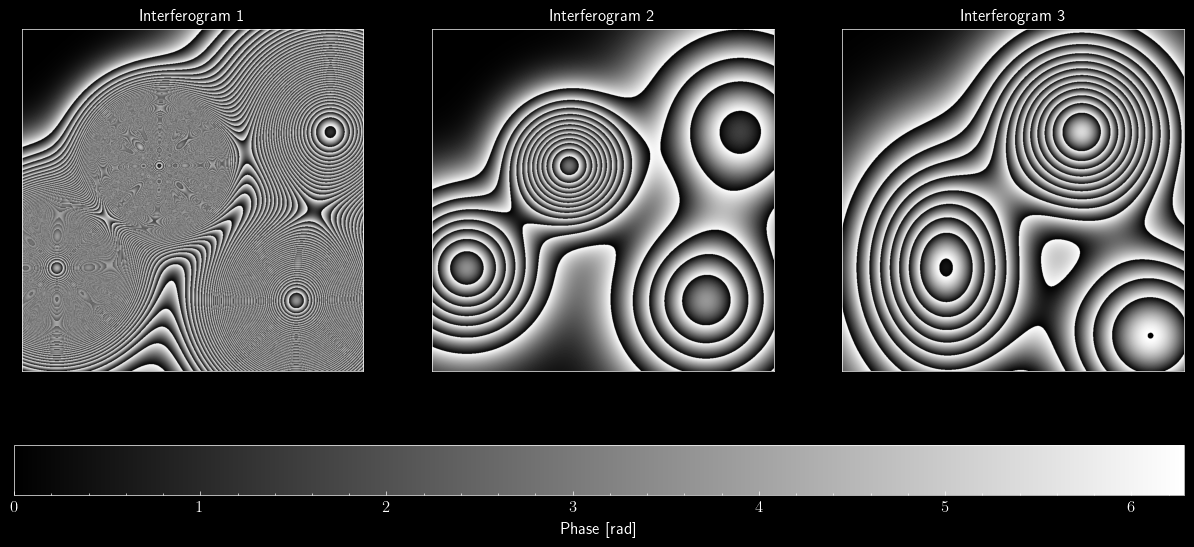

In [3]:
with plt.style.context('science'):
    fig = plt.figure(figsize=(15, 10))
    ax0 = fig.add_subplot(131)
    ax0.imshow(interfero1, cmap='gray')
    ax0.set_title('Interferogram 1')
    ax0.set_xticks([])
    ax0.set_yticks([])

    ax1 = fig.add_subplot(132)
    ax1.imshow(interfero2, cmap='gray')
    ax1.set_title('Interferogram 2')
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2 = fig.add_subplot(133)
    ax2.imshow(interfero3, cmap='gray')
    ax2.set_title('Interferogram 3')
    ax2.set_xticks([])
    ax2.set_yticks([])

    # Create a single horizontal colorbar
    cbar_ax = fig.add_axes([0.12, 0.2, 0.78, 0.05
                            ])  # Adjust the position and size of the colorbar
    cbar = fig.colorbar(ax2.imshow(interfero3, cmap='gray'),
                        cax=cbar_ax,
                        orientation='horizontal')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Phase [rad]', fontsize=12)


## 6.0.1 1D Unwrapping Algorithm

Basic outline:

-   start with arr $y$
-   take difference between neighbors of $y$:
    -   $\mathrm{d}y = y_{i+1} - y_{i}$
-   take difference between neighbors of $\mathrm{d}y$:
    -   $\mathrm{d}^2y = \mathrm{d}y_{i+1} - \mathrm{d}y_{i}$
-   **condition 1**:
    -   find all indices where $\left|\mathrm{d}y_i\right| > \pi$, with $i \in [0,\mathrm{len}(\mathrm{d}y)]$
        -   slice $y$ at all identified indices
-   **condition 2**:
    -   find indices where $\left|\mathrm{d}^2y_i\right| > 0$, with $i \in [0,\mathrm{len}(\mathrm{d}^2y)]$
        -   for two consecutive slices, the second one needs to be shifted by $+2\pi$ in magnitudes, relative to the first slice
    -   find indices where $\left|\mathrm{d}^2y_i\right| < 0$, with $i \in [0,\mathrm{len}(\mathrm{d}^2y)]$
        -   for two consecutive slices, the second one needs to be shifted by $-2\pi$ in magnitudes, relative to the first slice
-   apply to all indices and slices


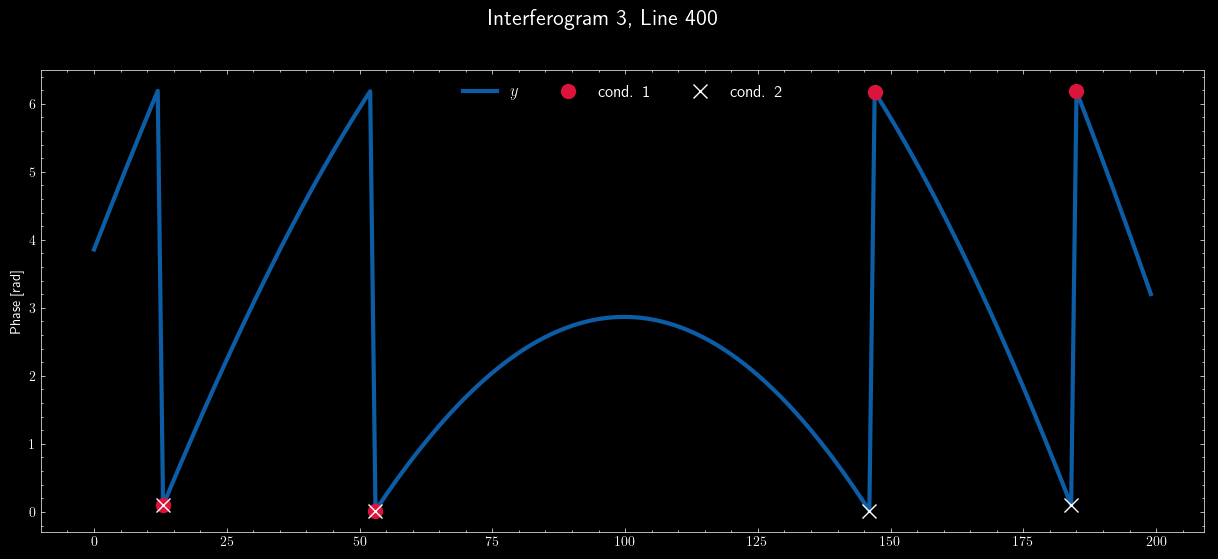

In [4]:
line3 = interfero3[399, :][600:800]

with plt.style.context('science'):
    fig = plt.figure(2, figsize=(15, 6))
    ax2 = fig.add_subplot(111)
    ax2.plot(line3, linewidth=3, label='$y$')
    ax2.plot(np.where(np.abs(np.diff(line3)) > np.pi)[0] + 1,
             line3[np.where(np.abs(np.diff(line3)) > np.pi)[0] + 1],
             linestyle='None',
             marker='o',
             markersize=10,
             color='crimson',
             label=r'cond. 1')
    ax2.plot(np.where(np.diff(np.diff(line3)) > 0)[0] + 1,
             line3[np.where(np.diff(np.diff(line3)) > 0)[0] + 1],
             linestyle='None',
             marker='x',
             markersize=10,
             color='white',
             label=r'cond. 2')
    ax2.set_ylabel('Phase [rad]')
    ax2.legend(fontsize=12, ncols=3, loc='upper center')

    fig.suptitle('Interferogram 3, Line 400', fontsize=16)


In [5]:
def unwrap_1d(line: np.ndarray) -> np.ndarray:
    _line = line.copy()
    diff = np.diff(_line)
    ddiff = np.diff(diff)
    indices = np.where(np.abs(diff) > np.pi)[0] + 1
    add = np.where(ddiff > 0)[0] + 1
    sub = np.where(ddiff < 0)[0] + 1

    for i in indices:
        if i in add:
            _line[i:] += 2 * np.pi
        elif i in sub:
            _line[i:] -= 2 * np.pi
        else:
            pass

    return _line

In [6]:
line_slider = IntSlider(value=400,
                        min=0,
                        max=len(interfero1) - 1,
                        step=1,
                        description='Line',
                        continuous_update=False)


@interact(line=line_slider)
def update(line):
    with plt.style.context('science'):
        fig = plt.figure(200, figsize=(15, 6))
        # plt.style.use('science')

        ax0 = fig.add_subplot(311)
        ax0.plot(interfero1[int(line - 1), :],
                 linewidth=2,
                 label='Interferogram 1')
        ax0.plot(unwrap_1d(interfero1[int(line - 1), :]),
                 linestyle='None',
                 marker='o',
                 markersize=5,
                 color='crimson',
                 label='Annealed')
        ax0.plot(unwrap_phase(interfero1[int(line - 1), :]),
                 color='white',
                 linestyle='None',
                 marker='.',
                 markersize=2,
                 label='Unwrapped')
        ax0.tick_params(axis='x', labelbottom=False)
        ax0.set_ylabel('Phase [rad]')
        ax0.legend(fontsize=12)

        ax1 = fig.add_subplot(312, sharex=ax0)
        ax1.plot(interfero2[int(line - 1), :],
                 linewidth=2,
                 label='Interferogram 2')

        ax1.plot(unwrap_1d(interfero2[int(line - 1), :]),
                 linestyle='None',
                 marker='o',
                 markersize=5,
                 color='crimson',
                 label='Annealed')
        ax1.plot(unwrap_phase(interfero2[int(line - 1), :]),
                 color='white',
                 linestyle='None',
                 marker='.',
                 markersize=1,
                 label='Unwrapped')
        ax1.tick_params(axis='x', labelbottom=False)
        ax1.set_ylabel('Phase [rad]')
        ax1.legend(fontsize=12)

        ax2 = fig.add_subplot(313, sharex=ax0)
        ax2.plot(interfero3[int(line - 1), :],
                 linewidth=2,
                 label='Interferogram 3')
        ax2.plot(unwrap_1d(interfero3[int(line - 1), :]),
                 linestyle='None',
                 marker='o',
                 markersize=5,
                 color='crimson',
                 label='Annealed')
        ax2.plot(unwrap_phase(interfero3[int(line - 1), :]),
                 color='white',
                 linestyle='None',
                 marker='.',
                 markersize=1,
                 label='Unwrapped')
        ax2.set_ylabel('Phase [rad]')
        ax2.legend(fontsize=12)

        fig.suptitle(f'Line {int(line)}', fontsize=16)

        plt.subplots_adjust(hspace=0)


interactive(children=(IntSlider(value=400, continuous_update=False, description='Line', max=999), Output()), _…

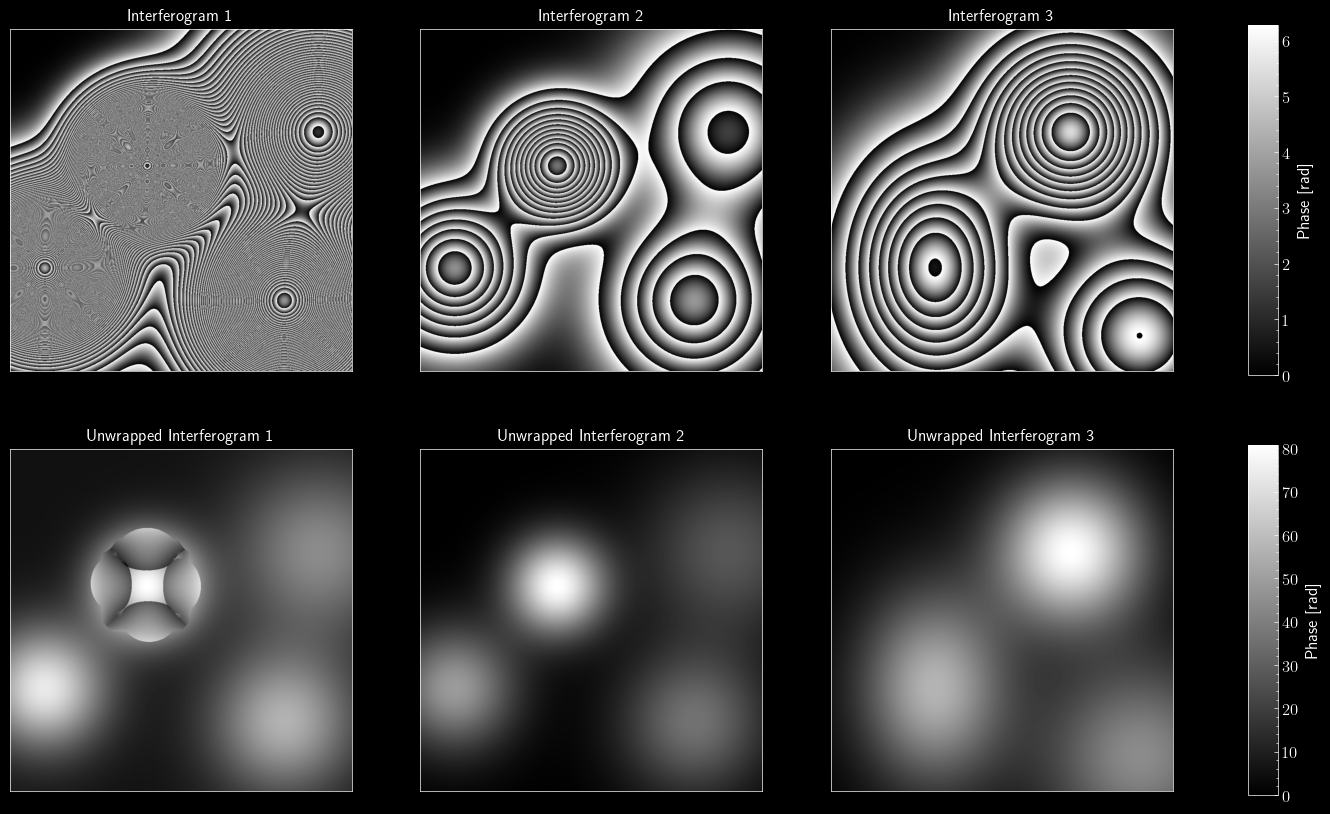

In [7]:
from calendar import c

with plt.style.context('science'):
    fig = plt.figure(figsize=(15, 10))
    ax0 = fig.add_subplot(231)
    ax0.imshow(interfero1, cmap='gray')
    ax0.set_title('Interferogram 1')
    ax0.set_xticks([])
    ax0.set_yticks([])

    ax1 = fig.add_subplot(232)
    ax1.imshow(interfero2, cmap='gray')
    ax1.set_title('Interferogram 2')
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2 = fig.add_subplot(233)
    ax2.imshow(interfero3, cmap='gray')
    ax2.set_title('Interferogram 3')
    ax2.set_xticks([])
    ax2.set_yticks([])

    # Create a single horizontal colorbar
    cbar_ax = fig.add_axes([0.95, 0.53, 0.02, 0.35
                            ])  # Adjust the position and size of the colorbar
    cbar = fig.colorbar(ax2.imshow(interfero3, cmap='gray'),
                        cax=cbar_ax,
                        orientation='vertical')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Phase [rad]', fontsize=12)

    ax3 = fig.add_subplot(234)
    ax3.imshow(unwrap_phase(interfero1), cmap='gray')
    ax3.set_title('Unwrapped Interferogram 1')
    ax3.set_xticks([])
    ax3.set_yticks([])

    ax4 = fig.add_subplot(235)
    ax4.imshow(unwrap_phase(interfero2), cmap='gray')
    ax4.set_title('Unwrapped Interferogram 2')
    ax4.set_xticks([])
    ax4.set_yticks([])

    ax5 = fig.add_subplot(236)
    ax5.imshow(unwrap_phase(interfero3), cmap='gray')
    ax5.set_title('Unwrapped Interferogram 3')
    ax5.set_xticks([])
    ax5.set_yticks([])

    # Create a single horizontal colorbar
    cbar_ax = fig.add_axes([0.95, 0.11, 0.02, 0.35
                            ])  # Adjust the position and size of the colorbar
    cbar = fig.colorbar(ax5.imshow(unwrap_phase(interfero3), cmap='gray'),
                        cax=cbar_ax,
                        orientation='vertical')
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Phase [rad]', fontsize=12)

## 6.1 Which interferogram(s) relate(s) to the given input DEM?


## 6.2 Do all results look valid? If not, what could be the reason?


## 6.3 What problems can occur during phase unwrapping?


## 6.4 To what input parameter do the fringes in the interferogram relate to, i.e. what parameter(s) need(s) to be considered to compute the relative heights?
